In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import sys 
import matplotlib.pyplot as plt
sys.path.insert(0,'..')
from utils import plot_stroke
import string

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

In [3]:
from sklearn.model_selection import KFold, train_test_split

In [4]:
strokes = np.load('../data/strokes-py3.npy', allow_pickle=True)
with open('../data/sentences.txt') as f:
    texts = f.readlines()

In [5]:
texts_length = [len(text) for text in texts]
strokes_length = [len(stroke) for stroke in strokes]
input_size = max(texts_length)
output_size = max(strokes_length)
print(input_size, output_size)

65 1191


In [6]:
# First, I would have the tendancy to "clean" the data, that is : 
# - lowercase
# - remove non alphanumerical characters
# It might be a little too much, but this is a first step to understand how I should go about doing the task
import re
pattern = re.compile("\W")
def clean_sentence(sentence):
    sentence = sentence.lower()
    return re.sub(pattern, " ", sentence).lower()
#print(clean_sentence("""ffrf"r"""))
#print(clean_sentence(texts[10]))
    
def pad_sentence(sentence, limit):
    # First, we need to zero-pad the inputs, because the sentence are all of variable length
    # The average length of sentences is 30 chars, with 95% of sentences between 20 and 60 chars
    # So we are going to zero pad every sequence that has less than 30 characters, and discard 
    # all the characters beyond the 30th
    l = len(sentence)
    if l > limit :
        return sentence[:limit]
    for i in range(l, limit):
        sentence += " "
    return sentence

def pad_sequence(sequence, limit):
    l = len(sequence)
    if l > limit :
        return sequence[:limit]
    for i in range(l, limit):
        sequence = np.append(sequence, [[0,0,0]],axis=0)
    return sequence

In [7]:
clean_texts = [clean_sentence(sentence) for sentence in texts]
texts_padded = [pad_sentence(string, input_size) for string in clean_texts]
# charset will provide the basis for letter embedding
charset = set()
for text in texts_padded:
    for char in text :
        charset.add(char)
charset = list(charset)
charset.sort()

In [26]:
def sentence_to_vector(sentence):
    sentence_vector = []
    for char in sentence :
        index = charset.index(char)
        sentence_vector.append(index)
    return sentence_vector

def vector_to_sentence(vector):
    sentence = ""
    for index in list(vector):
        print(index)
        sentence += charset[index]
    return sentence
    
sentence_vectors = []
for sentence in texts_padded :
    sentence_vector = sentence_to_vector(sentence)
    sentence_vectors.append(sentence_vector)
sentence_vectors = np.array(sentence_vectors)

In [27]:
sequence_vectors = []
output_size = 600
i = 0
for sequence in strokes :
    i += 1
    if i % 1000 == 0 :
        print(i)
        
    sequence_vector = pad_sequence(sequence, output_size) 
    sequence_vectors.append(sequence_vector)
sequence_vectors = np.array(sequence_vectors)

1000
2000
3000
4000
5000
6000


In [15]:
print(sequence_vectors.shape)
print(sentence_vectors.shape)
print(input_size, output_size)

(6000, 600, 3)
(6000, 65)
65 600


In [16]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, sentences, sequences):
        'Initialization'
        self.sentences = sentences
        self.sequences = sequences

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.sentences)


  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.sentences[index]
        y = self.sequences[index]

        return X, y


In [17]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 3*output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    def num_flat_features(self,x):
        size = x.size()[1:] # all dimensions except batch dimension
        num_features = 1
        for s in size :
            num_features *= s
        return num_features

In [18]:
max_epochs = 1000
cv = KFold(n_splits = 2)
params = {
    "batch_size" : 32
}

tol = 1e-4
n_iter_no_change = 10
X,y = sentence_vectors[:100], sequence_vectors[:100]
#X, y = sentence_vectors, sequence_vectors
for train_index, test_index in cv.split(X):
        ### Create a NEW neural network
        net = Net(input_size, output_size)
        null_net = Net(input_size, output_size)
        null_net = null_net.double()
        # Generate data
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        X_test, y_test = torch.tensor(X_test, dtype=torch.double), torch.tensor(y_test, dtype = torch.double)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)
        X_train, X_val = torch.tensor(X_train, dtype=torch.double), torch.tensor(X_val, dtype=torch.double)
        y_train, y_val = torch.tensor(y_train, dtype=torch.double), torch.tensor(y_val, dtype=torch.double)
        train_length = X_train.shape[0]
        validation_length = X_val.shape[0]
        testing_length = X_test.shape[0]
        training_set = Dataset(X_train, y_train)
        validation_set = Dataset(X_val, y_val)
        testing_set = Dataset(X_test, y_test)
        training_generator = data.DataLoader(training_set, **params)
        validation_generator = data.DataLoader(validation_set, **params)
        testing_generator = data.DataLoader(testing_set, **params)
        # Create optimizer
        optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001)
        criterion = nn.MSELoss()
        
        # Prepare logging
        train_losses = []
        validation_losses = []
        null_validation_losses = []
        best_validation_loss = 1e10
        no_improvement_count = 0
        
        for epoch in range(1,max_epochs+1) :
            # Training
            minibatch_number = 1
            loss_sum = 0
            for local_batch, local_labels in training_generator:
                optimizer.zero_grad()   # zero the gradient buffers
                net = net.double()
                output = net(local_batch)
                labels = local_labels.reshape(output.shape)
                loss = criterion(output, labels.double())
                loss.backward()
                optimizer.step() # Does the update
                loss_sum += loss.item()
                minibatch_number += 1
            train_loss = loss_sum / train_length
            train_losses.append(train_loss)
            
            # Validation
            minibatch_number = 1
            loss_sum = 0
            null_loss_sum = 0
            with torch.set_grad_enabled(False):
                for local_batch, local_labels in validation_generator:
                    output = net(local_batch)
                    null_output = null_net(local_batch)
                    labels = local_labels.reshape(output.shape)
                    loss = criterion(output, labels.double())
                    null_loss = criterion(null_output, labels.double())
                    loss_sum += loss.item()
                    null_loss_sum += null_loss.item()
                    minibatch_number += 1
            validation_loss = loss_sum / validation_length
            null_validation_loss = null_loss_sum / validation_length
            validation_losses.append(validation_loss)
            null_validation_losses.append(null_validation_loss)
            # Check for early-stopping
            if validation_loss > (best_validation_loss - tol):
                no_improvement_count += 1
            else :
                no_improvement_count = 0
            if validation_loss < best_validation_loss :
                best_validation_loss = validation_loss
            if epoch % 5 == 0 :
                print("epoch {}".format(epoch))
            if no_improvement_count > n_iter_no_change :
                # The loss hasn't improved by 'tol' for more than 'n_iter_no_change' epochs
                print("Early stopping at epoch {}".format(epoch))
                break

epoch 5
epoch 10
epoch 15
epoch 20
Early stopping at epoch 23
epoch 5
epoch 10
epoch 15
epoch 20
epoch 25
Early stopping at epoch 26


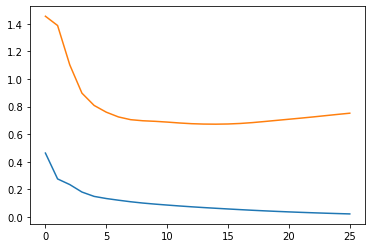

In [19]:
plt.plot(train_losses)
plt.plot(validation_losses)

torch.Size([65])
torch.Size([65])
torch.Size([])
tensor([[ 0.0000,  0.4719, -0.6530],
        [ 0.0000,  1.2393,  1.2499],
        [ 0.0000,  0.0907, -0.2811],
        ...,
        [ 0.0000,  5.0322,  2.4644],
        [ 1.0000,  0.2880, -1.5245],
        [ 0.0000,  0.3962,  1.1262]], dtype=torch.float64)


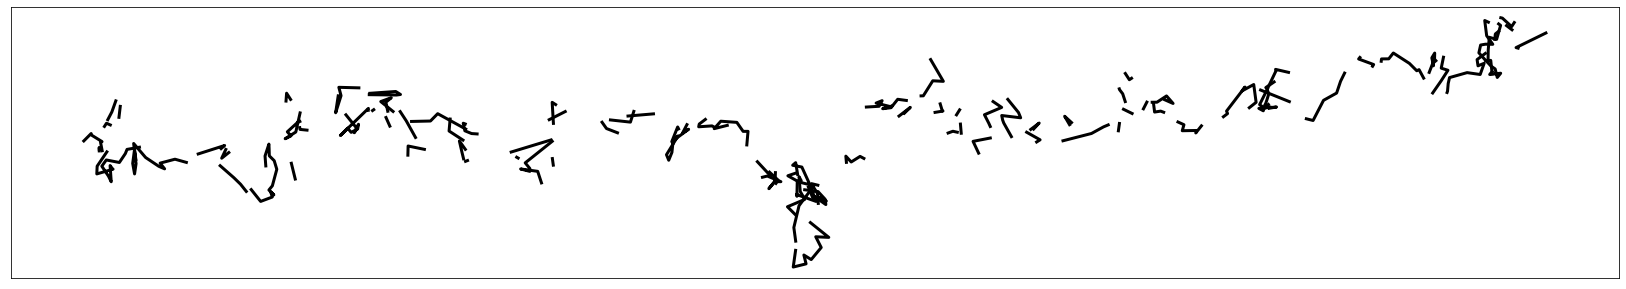

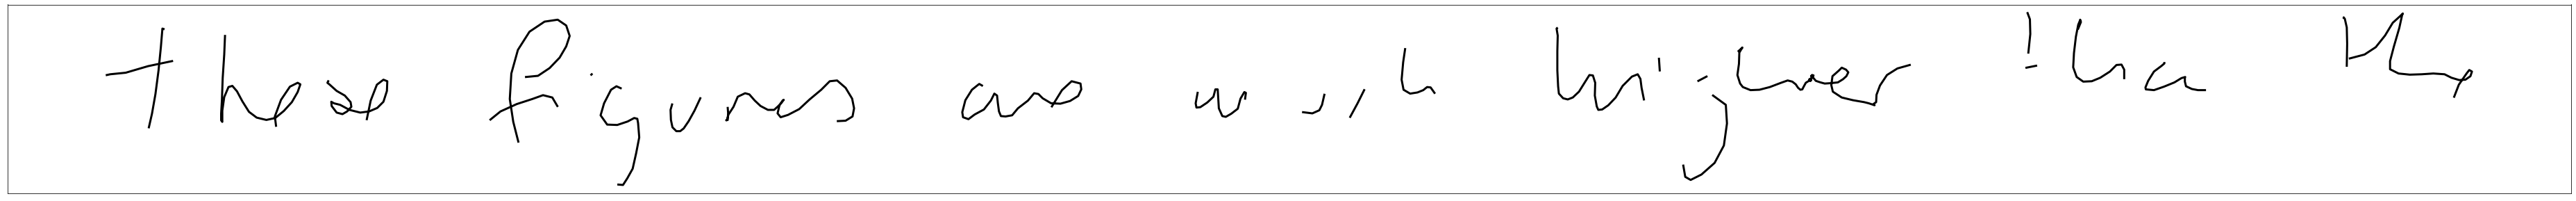

In [38]:
with torch.set_grad_enabled(False):
    o = net(X_test[0])
o = o.reshape(600,3)
print(X_test[0].shape)
print(X_test[0].reshape(65).shape)
print(X_test[0][0].shape)
#print(vector_to_sentence(int(X_test[0].float())))
for i in range(len(o)):
    if o[i][0] > 0.8 :
        o[i][0] = 1
    else : 
        o[i][0] = 0
print(o)
plot_stroke(o)
plot_stroke(y_test[0])

In [40]:
sequences_padded.index(y_test[0].numpy())

NameError: name 'sequences_padded' is not defined